In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [6]:
data= pd.read_csv("../input/creditcardfraud/creditcard.csv")

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
Not_Fraudulent,Fraudulent= data["Class"].value_counts()

99.82725143693798
0.1727485630620034


<AxesSubplot:xlabel='Class', ylabel='count'>

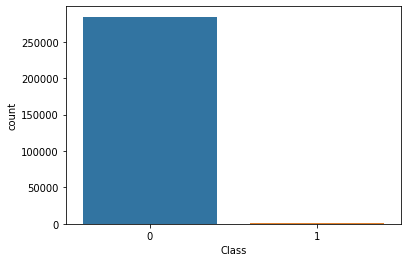

In [9]:
print((Not_Fraudulent/len(data["Class"]))*100),
print((Fraudulent/len(data["Class"]))*100)
sns.countplot("Class",data=data)

****There is a huge Class imbalance problem
and chances are that we might overfit the problem and not detect anomalies at all.Also, since all the data is scaled, we shall scale time and amount as  well.****

# Scaling Time And Amount

In [10]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


# DEALING WITH CLASS IMBALANCE

*Class Imbalance is dealt in this case by downsampling the NON_FRAUD Cases to the count of the Fraud Cases.*

**CASE-1:
Under_Sampled and then used Train_Test_Split**


****CASE_2:
First did the Train_Test Split and then undersampling****

**CASE_1:**

In [21]:
data = data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
179400,1.631426,-1.190461,0.368862,0.603189,-1.752517,-0.482712,-1.034331,0.132018,1.724706,-0.063655,...,0.704225,0.192390,0.422268,-0.740556,0.590978,-0.029414,-0.007655,0,1.899672,0.462494
150665,-6.750509,5.367416,-10.054635,9.064478,-7.968118,-2.263798,-10.317566,4.237666,-5.324109,-11.092392,...,-0.348740,0.425001,0.674909,-0.784208,-0.247422,1.159581,0.197818,1,2.622092,0.107661
262604,1.916364,-0.336464,-1.443948,0.348206,0.303412,-0.158697,0.102017,-0.057710,0.365189,0.214592,...,-0.669498,0.221786,0.344916,-0.193273,0.024291,-0.080013,-0.054795,0,0.654929,0.891282
221041,-1.172183,1.661713,-3.049637,2.555058,3.669035,-3.162998,-5.985640,-2.179935,-1.120292,-3.075558,...,-0.295361,-5.988806,0.714381,-1.600024,-0.634783,0.822713,0.494375,1,-0.279466,0.678074
147605,1.917827,0.951967,-2.059206,3.833998,1.668192,0.769826,0.232463,0.107941,-1.143646,0.541699,...,0.239994,-0.111916,-0.380576,0.370995,0.189117,-0.005823,-0.012105,1,-0.178719,0.047522


In [ ]:
f,ax1 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

X_has= new_df.drop("Class",axis=1)
y_has= new_df["Class"]

# train and test data
X_train, X_test, y_train, y_test = train_test_split(X_has, y_has)

In [24]:
model= LogisticRegression()
model.fit(X_has,y_has)
y_pred= model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       111
           1       0.98      0.90      0.94       135

    accuracy                           0.93       246
   macro avg       0.93      0.94      0.93       246
weighted avg       0.94      0.93      0.94       246



**CASE:2**

In [29]:
X_bf=data.drop("Class",axis=1)
y_bf=data["Class"]
X_train_bf,X_test_bf,Y_train_bf,Y_test_bf= train_test_split(X_bf,y_bf)

In [37]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# check the balanced data
print(pd.Series(y_rus).value_counts())


0    357
1    357
Name: Class, dtype: int64


In [39]:
undersampledlatermodel= LogisticRegression()
undersampledlatermodel.fit(X_rus,y_rus)
y_pred_undersampled_later= undersampledlatermodel.predict(X_rus)


print(classification_report(y_rus,y_pred_undersampled_later))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       357
           1       0.99      0.95      0.97       357

    accuracy                           0.97       714
   macro avg       0.97      0.97      0.97       714
weighted avg       0.97      0.97      0.97       714



****WE CAN SEE THAT CASE-2 HAS A BETTER REPORT THAN CASE-1****

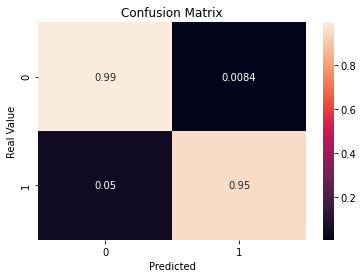

In [42]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_rus, y_pred_undersampled_later, normalize='true'), annot=True, ax=ax)

ax.set_title("Confusion Matrix")
ax.set_ylabel("Real Value")
ax.set_xlabel("Predicted")

plt.show()

In [47]:
from sklearn.tree import export_graphviz,DecisionTreeClassifier
model_tree= DecisionTreeClassifier()
model_tree.fit(X_rus,y_rus)
y_pred_undersampledrus= model_tree.predict(X_rus)

print(classification_report(y_rus,y_pred_undersampledrus))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       1.00      1.00      1.00       357

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714



In [52]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [51]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 635 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=00b5771c8d56c40dec0467d0e78e6a050c501473332e0eaab40d09b86e839972
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


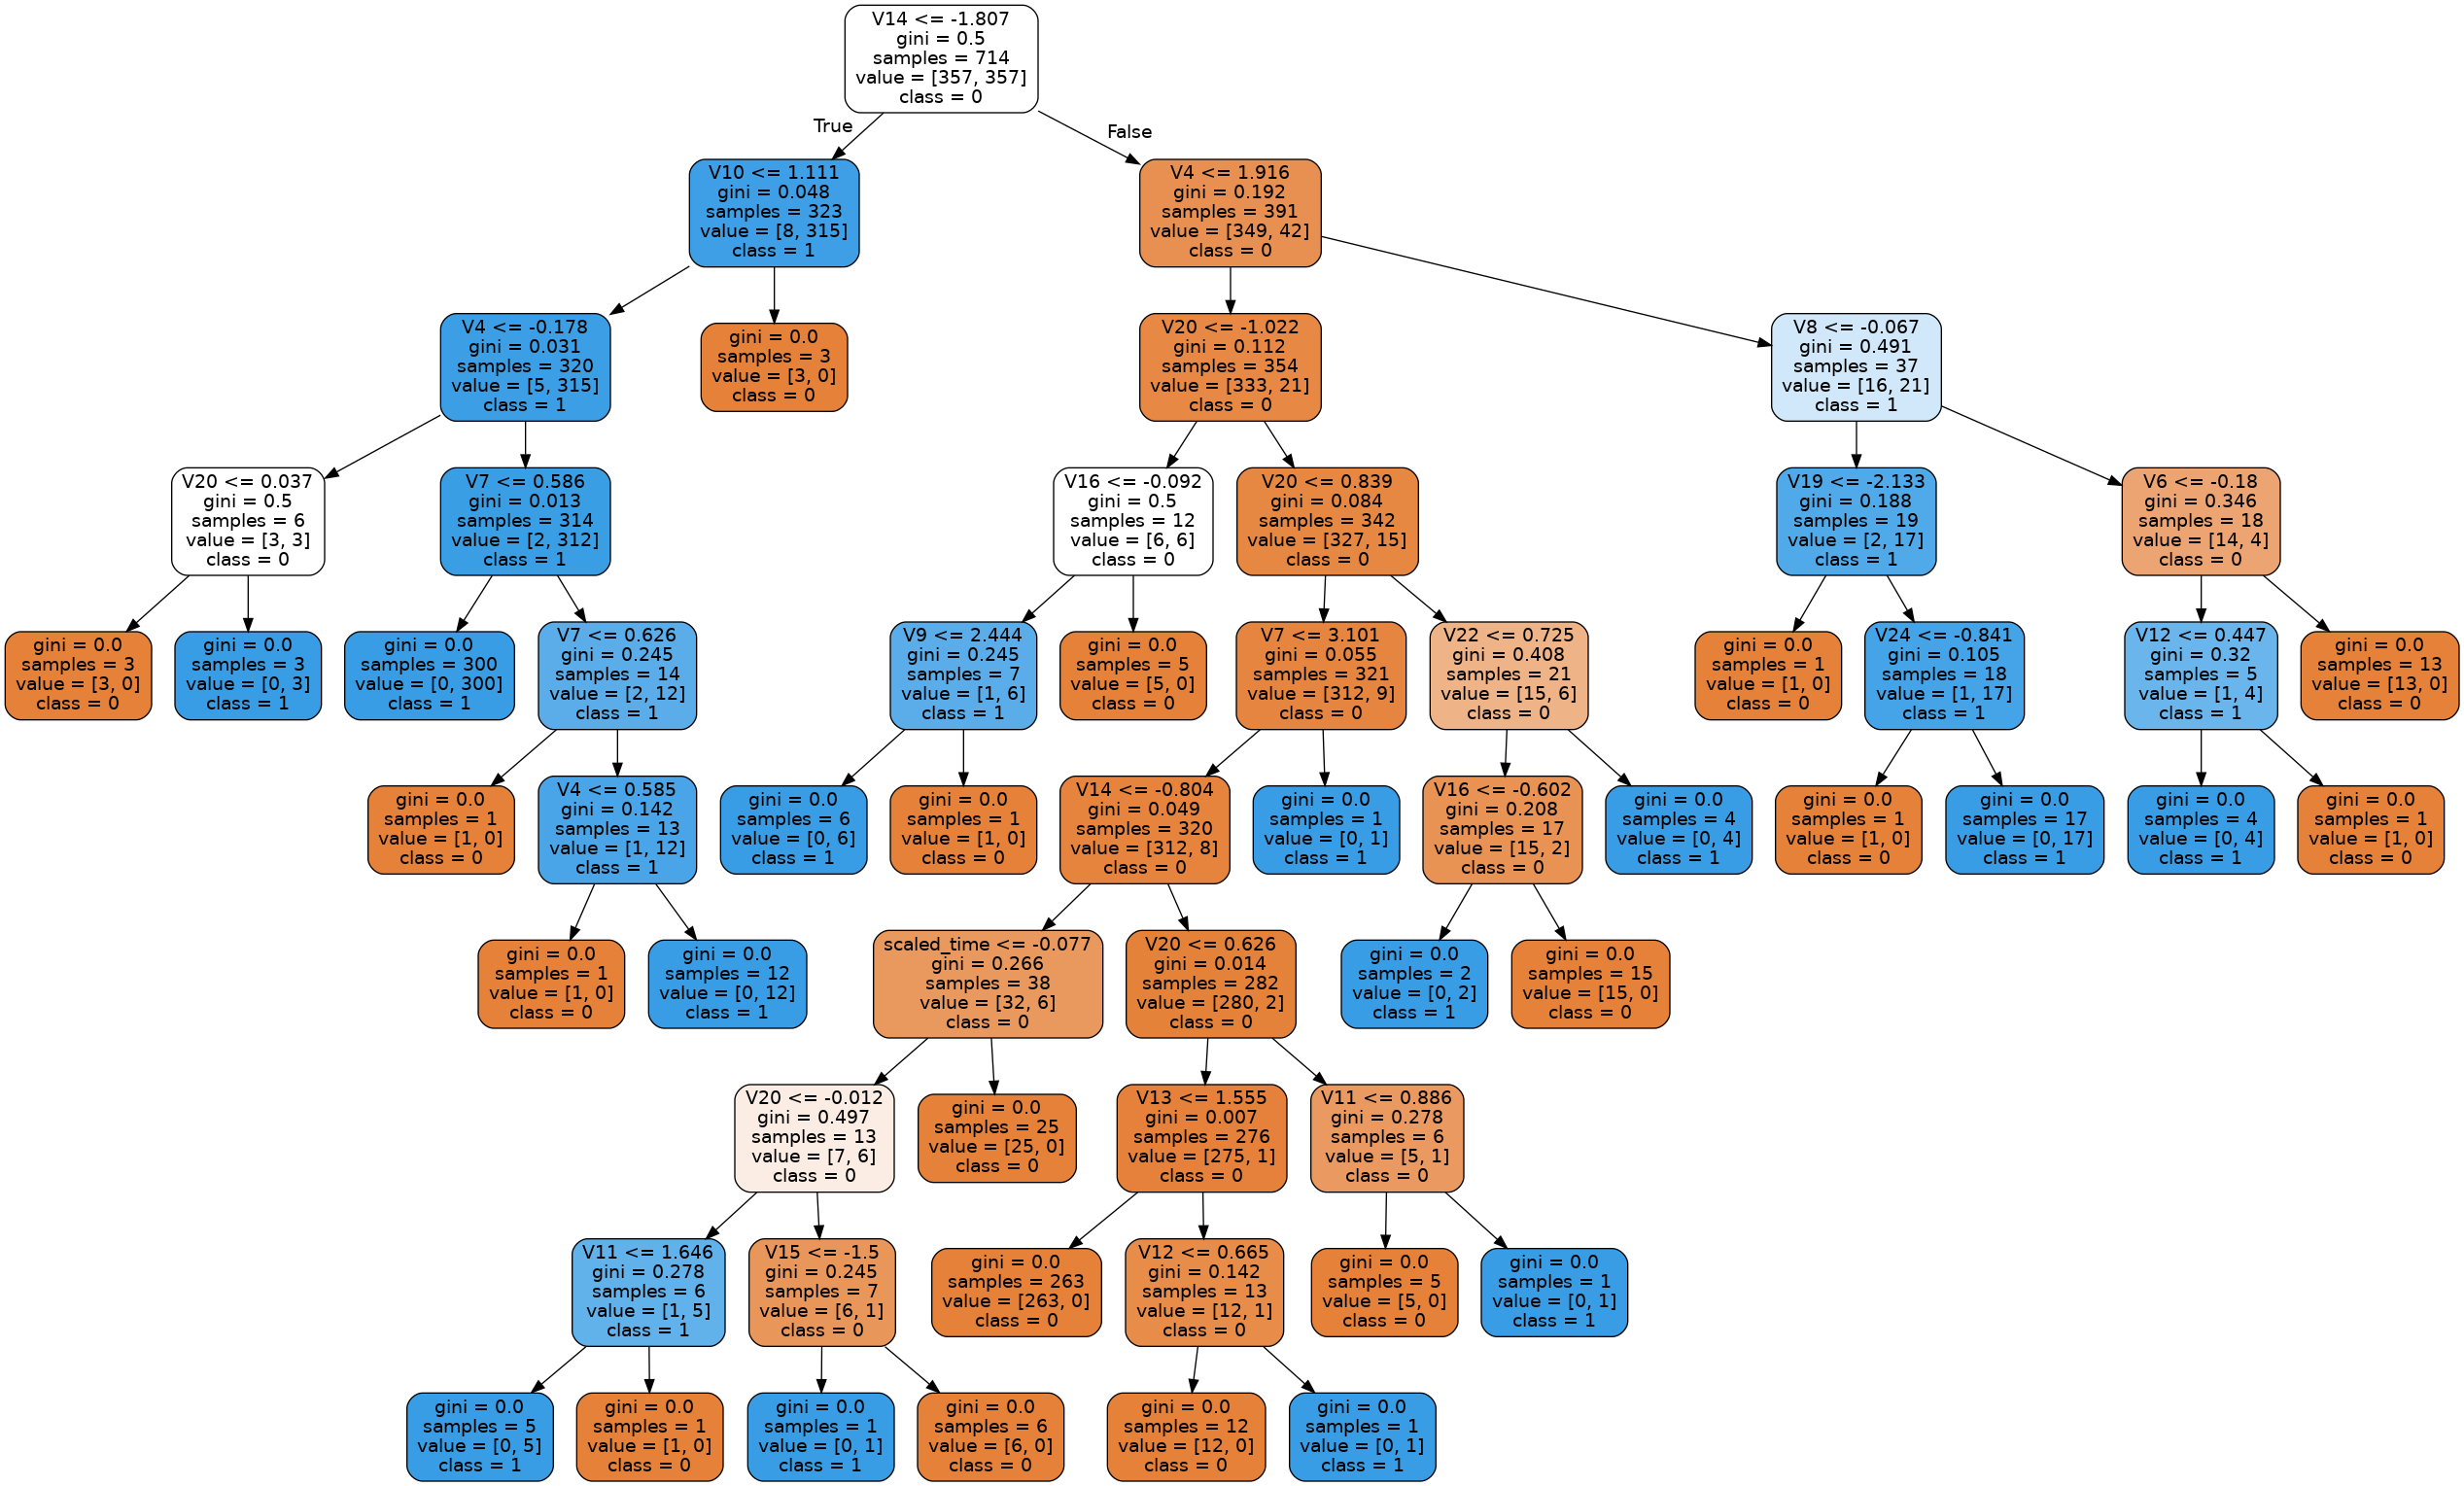

In [53]:
dot = export_graphviz(model_tree, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())